# Homework 3 - CNN on Multilabel remote sensing images
## By: Syed Ali Murad Tahir

In this homework we will be performing CNN on UCMerced dataset. This dataset contains Multispectral images. 

Tasks for this homework:
1) Importing data
2) Training data
3) Data Augmentation on training data
4) 




The task is divided into following step

1)  Prepairing data
2) The data we get, we divide that data, into training, test and validation. We divide training data into training and test
3) To pretrain the model in order to avoid overfitting, we can use pretrained data already provided to us. Or, we can perform data augmentation
to pre train the data so we have more samples of data
4) Now we perform Convolution. So we choose the number of layers, neuron in that layer and the activation function of that layer (Check if need to perform padding before,). For padding check the following link: https://www.youtube.com/watch?v=mTVf7BN7S8w&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO&index=27
5) Then we add Max pooling to take out dominant features
6) We can add dropout
7) Then we have to perform flatten the data
8) We can add a desne layer (Check if we need it or not) -> These are actually the hidden layers we specify when performing forward propgation
9) Then we train or data
10) After that we check our results on test data to check for overfitting
11) At the end we check validation


## Understanding the dataset

This is a 21 class land use image dataset meant for research purposes. However, for multilabel, we only have 17 labels

There are 100 images for each of the following classes:
    
    
 1) airplane	
 2) bare-soil	
 3) buildings	
 4) cars	
 5) chaparral	
 6) court	
 7) dock	
 8) field	
 9) grass	
 10) mobile-home	
 11) pavement	
 12) sand	
 13) sea	
 14) ship	
 15) tanks	
 16) trees	
 17) water

Each image measures 256x256 pixels.



In [25]:
import copy
import os
import numpy as np
import pandas as pd
from pathlib import *
import zipfile
import matplotlib.pyplot as plt
from simple_downloader import download
from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix



import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, Subset, DataLoader

## Importing Dataset

In [22]:
#For removing directory and all files inside the directory. 
""" I created it so I don't have to delete all the files one by one in case I need to empty the folder"""
"""
path = os.path.join("/notebooks", "Hw3data_modified", "")
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        os.remove(os.path.join(root, name))
    for name in dirs:
        os.rmdir(os.path.join(root, name))


os.chdir("/notebooks")
"""


In [23]:
download_dir = Path("./Hw3data_modified")
download_dir.mkdir(exist_ok=True)

In [24]:
TUB_URL = "https://tubcloud.tu-berlin.de/s/H4QHX5GPDY6wDog/download/UCMerced_LandUse.zip"
output_file = download(TUB_URL, "./Hw3data_modified/")

UCMerced_LandUse.zip ━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% | 332.9/332.9 MB | 2.7 MB/s | 0:00:00
      All_Images.zip ━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% | 331.5/331.5 MB | 8.0 MB/s | 0:00:00
      All_Images.zip ━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% | 331.5/331.5 MB | 7.5 MB/s | 0:00:00
UCMerced_LandUse.zip ━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 100.0% | 332.8/332.9 MB | 4.9 MB/s | 0:00:01

In [25]:
zipf = zipfile.ZipFile(output_file)
zipf.extractall(path="Hw3data_modified")

In [2]:
#Go to different file directory
path = os.path.join("/notebooks", "Hw3data_modified", "UCMerced_LandUse", "multilabels", "")
os.chdir(path)




# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))


data = pd.DataFrame(pd.read_excel("LandUse_Multilabeled.xlsx"))
data

Current working directory: /notebooks/Hw3data_modified/UCMerced_LandUse/multilabels


,IMAGE\LABEL,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water
0,agricultural00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,agricultural01,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,agricultural02,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,agricultural03,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,agricultural04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,tenniscourt95,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
2096,tenniscourt96,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0
2097,tenniscourt97,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0
2098,tenniscourt98,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0


            Number of labels
airplane                 100
bare-soil                718
buildings                691
cars                     886
chaparral                115
court                    105
dock                     100
field                    103
grass                    975
mobile-home              102
pavement                1300
sand                     294
sea                      100
ship                     102
tanks                    100
trees                   1009
water                    203


Text(0.5, 1.0, 'Total no. of labels that belong to each class')

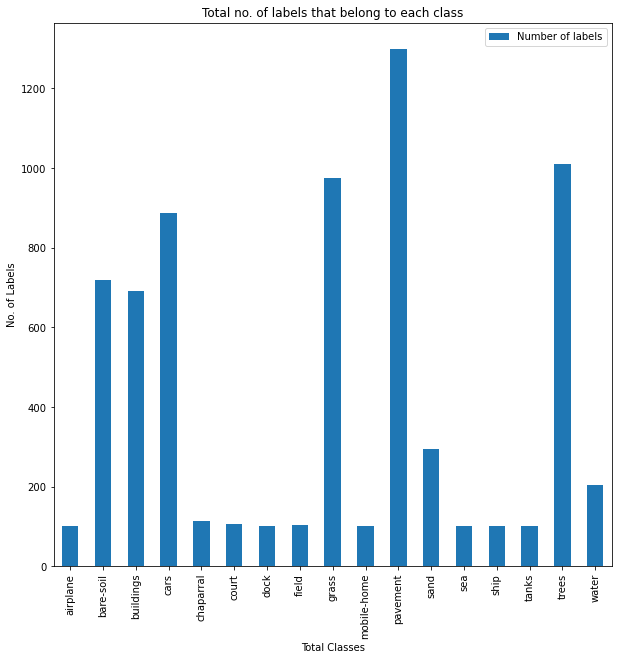

In [26]:
result = data.sum(axis="rows")
df = pd.DataFrame(result,columns=['Number of labels'])   #Convert into Data Frame
#Drop the first row
df.drop(index=df.index[0], 
        axis=0, 
        inplace=True)
print(df)


df.plot.bar(figsize=(10,10))
plt.xlabel("Total Classes")
plt.ylabel("No. of Labels")
plt.title("Total no. of labels that belong to each class")



Since we have images in different folder, we can create a new folder and move all of them there

In [28]:
#We move all images to one folve all images to one folder
os.chdir("/notebooks")
TUB_URL = "https://tubcloud.tu-berlin.de/s/ByA4webNJcpYDSK/download/All_Images.zip"
output_file = download(TUB_URL, "")

Target file already exists!
Will skip download. To force download set `force=True`


In [29]:
zipf = zipfile.ZipFile(output_file)
zipf.extractall()

In [30]:
path = os.path.join("/notebooks", "Hw3data_modified", "UCMerced_LandUse", "multilabels", "")
os.chdir(path)

print("Current working directory: {0}".format(os.getcwd()))


#Load all classes for all images
data = pd.read_excel("LandUse_Multilabeled.xlsx")



Current working directory: /notebooks/Hw3data_modified/UCMerced_LandUse/multilabels


## Design the Data Pipeline

In [28]:
#importing pandas as pd
import pandas as pd
path = os.path.join("/notebooks", "Hw3data_modified", "UCMerced_LandUse", "multilabels", "")
os.chdir(path)
  
# Read and store content
# of an excel file 
read_file = pd.read_excel("LandUse_Multilabeled.xlsx")
  
# Write the dataframe object
# into csv file
read_file.to_csv("LandUse_Multilabeled.csv", 
                  index = None,
                  header=True)
    
# read csv file and convert into a dataframe object
df = pd.DataFrame(pd.read_csv("LandUse_Multilabeled.csv"))
df

,IMAGE\LABEL,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water
0,agricultural00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,agricultural01,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,agricultural02,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,agricultural03,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,agricultural04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,tenniscourt95,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
2096,tenniscourt96,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0
2097,tenniscourt97,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0
2098,tenniscourt98,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0


In [29]:
#Create class labels
classLabels = ["airplane", "bare-soil", "buildings", "cars","chaparral", "court", "dock", "field", "grass", "mobile-home","pavement","sand", "sea","ship",
               "tanks", "trees", "water"]


In [61]:
import os
os.chdir("/notebooks")
os.getcwd()

'/notebooks'

In [64]:
import argparse
import csv
import os

import numpy as np
from PIL import Image
from tqdm import tqdm



def save_csv(data, path, fieldnames=['image_path', 'airplane', 'bare_soil', 'buildings', 'cars', 'chaparral', 'court', 'dock', 'field', 'grass', 'mobile_home', 
                                     'pavement', 'sand', 'sea', 'ship', 'tanks', 'trees', 'water']):
    with open(path, 'w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for row in data:
            writer.writerow(dict(zip(fieldnames, row)))


In [65]:
import csv



annotation = 'LandUse_Multilabeled.csv'

all_data = []
# open annotation file
with open(annotation) as csv_file:
    # parse it as CSV
    reader = csv.DictReader(csv_file)
    # tqdm shows pretty progress bar
    # each row in the CSV file corresponds to the image
    for row in tqdm(reader, total=reader.line_num):
        # we need image ID to build the path to the image file
        img_id = row['IMAGE\LABEL']
        # we're going to use only 3 attributes
        airplane = row['airplane']
        bare_soil = row['bare-soil']
        buildings = row['buildings']
        cars = row['cars']
        chaparral = row['chaparral']
        court = row['court']
        dock = row['dock']
        field = row['field']
        grass = row['grass']
        mobile_home = row['mobile-home']
        pavement = row['pavement']
        sand = row['sand']
        sea = row['sea']
        ship = row['ship']
        tanks = row['tanks']
        trees = row['trees']
        water = row['water']
        
        img_name = os.path.join('/notebooks', 'All_Images', str(img_id) + '.tif')
        # check if file is in place
        if os.path.exists(img_name):
            # check if the image has 80*60 pixels with 3 channels
            img = Image.open(img_name)
            if img.size == (60, 80) and img.mode == "RGB":
                all_data.append([img_name, airplane, bare_soil, buildings, cars, chaparral, court, dock, field, grass, mobile_home, pavement,
                                 sand, sea, ship, tanks, trees, water])
                print(all_data)
        else:
            print("Something went wrong: there is no file ", img_name)
            




# set the seed of the random numbers generator, so we can reproduce the results later
np.random.seed(42)
# construct a Numpy array from the list
all_data = np.asarray(all_data)

# Take 40000 samples in random order
inds = np.random.choice(2100, replace=False)
# split the data into train, val, test and save them as csv files
save_csv(all_data[inds][:1470], os.path.join('/notebooks', 'train2.csv'))
save_csv(all_data[inds][1471:1680], os.path.join('/notebooks','val2.csv'))
save_csv(all_data[inds][1681:2100], os.path.join('/notebooks', 'test2.csv'))

2100it [00:00, 2281.30it/s]

[]


IndexError: index 1034 is out of bounds for axis 0 with size 0

In [48]:
print(all_data)

[]


In [8]:
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path
from torchvision.models import ResNet18_Weights
from torch.optim import Adam


class MyDataset(Dataset):
  def __init__(self , csv_file , img_dir , transforms=None ):
    
    self.df = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transforms = transforms
    
  def __getitem__(self,idx):
    img_path = self.img_dir[idx]
    
    img = Image.open(img_path).convert("RGB")
    label = torch.tensor(img_path[1:].tolist() , dtype=torch.float32)
    if self.img_transform is not None:
        img = self.img_transform(img)

    return dict(img=img, label=label)


  
  def __len__(self):
    return len(self.df)


In [9]:
#Transform the data
#  We also want to normalize the dataset and make sure all datasets have the same size

transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(), #0-255 -> 0-1. Also changes numpy -> Tensors
    transforms.Normalize([0.595425, 0.3518577, 0.3225522],                
                        [0.19303136, 0.12492529, 0.10577361]),
      
])

#LandUse_csv = Path(r"/notebooks/Hw3data_modified/UCMerced_LandUse/multilabels/LandUse_Multilabeled.csv")
#f = open(LandUse_csv)
dataset = MyDataset("LandUse_Multilabeled.csv", Path("All_Images") , transform)

## Training Design

In this part, we will be creating a CNN. In order to perform CNN, we
1) Divide our data into training, test and validation. We provide 70% data to training, 20% for testing and 10% for validation. 
2) After that, we create the Convolution layer. In this case we use the pytorch pretrained resnet 18 model
3) For criterion, we use a #Criterion BCEWithLogitsLoss function
4) For optimizer, we use Adam optimizer. It is the same as stochastic gradient descent
5) We create a dense layer that used for training the model
6) We evaluate the model in order to check whether the model is overfitting or underfitting
7) Test the model for unseen data

### Train - Test divide

In the first part, we divide our dataset into training test and validation. We provide 80% data to training, 10% to validation and 10% to test.

In [10]:
# Divide data into train, test and validation
valid_no = int(len(dataset)*0.1)
train_no = int(len(dataset)*0.7) 
test_no = int(len(dataset)*0.2)
train_val = int(len(dataset)*0.8) 

print("No: of dataset for training: {}, validation: {}, testing: {}".format(train_no, valid_no, test_no))


#Split data into training, validation, and testing
trainset ,validset, testset  = random_split(dataset , [train_no, valid_no, test_no])


print("\n")
print("We want to check if data actually splitted the way we anticipated")
print(f"trainset: {len(trainset)} valset: {len(validset)} testset: {len(testset)}")


No: of dataset for training: 1470, validation: 210, testing: 420


We want to check if data actually splitted the way we anticipated
trainset: 1470 valset: 210 testset: 420


In [11]:
batch_size = 64
dataloader = {"train":DataLoader(trainset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(validset , shuffle=False , batch_size=batch_size),
              "test": DataLoader(testset , shuffle=False , batch_size=batch_size)
             }
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)

### Define Device

In [12]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Define Model

Generally we have to create a 2-3 layer CNN an before creating a dense network to perform Forward and backpropogation (please refer to line 26 of Lab07). 
However, in this case we are told RESNET18. THis is an already built CNN. Hence, we don't need to create convoltuion layers and dense layer by ourself. 
We just need to adjust the values and RESNET18 will train the model by itself.

To understand RESNET18, check the following links: https://www.youtube.com/watch?v=K0lWSB2QoIQ https://www.coursera.org/lecture/ai-deep-learning-capstone/pre-trained-models-with-resnet-18-review-pytorch-F0nDe

In [13]:
model = models.resnet18(pretrained = True)
model.fc = nn.Linear(512, 17) #21 - number of classes
model.to(device)

"""
model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)
## freeze the entire convolution base
for param in model.parameters():
  param.requires_grad_(False)
 """

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

'\nmodel = models.resnet50(pretrained=True) # load the pretrained model\nnum_features = model.fc.in_features # get the no of on_features in last Linear unit\nprint(num_features)\n## freeze the entire convolution base\nfor param in model.parameters():\n  param.requires_grad_(False)\n '

### Optimizer and Criterion


In [14]:
import torch.optim as optim
from torch.optim import lr_scheduler


#Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


#Criterion
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()




# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [15]:
from tqdm import trange
from sklearn.metrics import precision_score,f1_score

def train(model , data_loader , criterion , optimizer ,scheduler, num_epochs=5):

  for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase in ['train', 'val']:
      if phase=="train":     # put the model in training mode
        model.train()
        scheduler.step()
      else:     # put the model in validation mode
        model.eval()
       
      # keep track of training and validation loss
      running_loss = 0.0
      running_corrects = 0.0  
      
      for data , target in data_loader[phase]:
        #load the data and target to respective device
        data , target = data.to(device)  , target.to(device)

        with torch.set_grad_enabled(phase=="train"):
          #feed the input
          output = model(data)
          #calculate the loss
          loss = criterion(output,target)
          preds = torch.sigmoid(output).data > 0.5
          preds = preds.to(torch.float32)
          
          if phase=="train"  :
            # backward pass: compute gradient of the loss with respect to model parameters 
            loss.backward()
            # update the model parameters
            optimizer.step()
            # zero the grad to stop it from accumulating
            optimizer.zero_grad()


        # statistics
        running_loss += loss.item() * data.size(0)
        running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)
        
        
      epoch_loss = running_loss / len(data_loader[phase].dataset)
      epoch_acc = running_corrects / len(data_loader[phase].dataset)

      result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print(result)

In [16]:
train(model,dataloader, criterion, optimizer,sgdr_partial,num_epochs=10)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/envs/ip4rs/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


TypeError: 'PosixPath' object is not subscriptable

In [16]:
epoch = 0
iteration = 0
while True:
    batch_losses = []
    for imgs, targets in train_loader:
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()

        model_result = model(imgs)
        loss = criterion(model_result, targets.type(torch.float))

        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()

        batch_losses.append(batch_loss_value)

        if iteration % test_freq == 0:
            model.eval()
            with torch.no_grad():
                model_result = []
                targets = []
                for imgs, batch_targets in test_dataloader:
                    imgs = imgs.to(device)
                    model_batch_result = model(imgs)
                    model_result.extend(model_batch_result.cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())

            result = calculate_metrics(np.array(model_result), np.array(targets))
            print("epoch:{:2d} iter:{:3d} test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch, iteration,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))

            model.train()
        iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iteration, loss_value))
    if epoch % save_freq == 0:
        checkpoint_save(model, save_path, epoch)
    epoch += 1
    if max_epoch_number < epoch:
        break

NameError: name 'idx' is not defined